In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
import datetime
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path

pl.enable_string_cache()

### functions to draw cue box and assign sex

In [99]:

from coral.config_loader import ConfigLoader
from coral.experimental_metadata import ExperimentMetaData
from coral.data_preprocessor import BehaviorDataPreprocessor, PhotometryDataPreprocessor
config_path = '/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/LH_NAC_Headfix_FP/Photometry/Pav_Training/claire_cohort/conf/config.yaml'
configs = ConfigLoader(config_path)

In [100]:
def draw_cue_box(ax, color, alpha):
    #  draw box on plot for cue
    y_lower = ax.get_ylim()[0]
    y_ags_sum = sum(np.abs(ax.get_ylim()))
    rect = patches.Rectangle(
        (0, y_lower), width=5, height=y_ags_sum, alpha=alpha, facecolor=color)
    ax.add_patch(rect)
    return rect


### paths to data

In [124]:
behavior_path = Path(
    '/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/LH_NAC_Headfix_FP/Photometry/Pav_Training/claire_cohort/analyzed_data/aggregated_data/aggregated_behavior_data.parquet')
fp_path = Path('/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/LH_NAC_Headfix_FP/Photometry/Pav_Training/claire_cohort/analyzed_data/aggregated_data/aggregated_photometry_data.parquet')
filter_date = datetime.date(2024, 2, 12)

In [168]:
bh_df = pl.read_parquet(behavior_path).drop("__index_level_0__").sort('date').sort('subject')


baselines = (bh_df
             .filter(
                 (pl.col('time') <0) 
                 & 
                 (pl.col('time') > -3))
             .group_by(['subject', 'date']).mean()
             .drop(['time', 'time_recorded', 'user'])
             .sort('date', descending=True)
             )
baseline_corrected_df = (bh_df
                        #  .filter(pl.col('date') > filter_date)
             .join(baselines, on = ['subject', 'date'], how = 'left', suffix = '_baseline')
             .with_columns(
                 (pl.col('encoder_aligned_to_cue') - pl.col('encoder_aligned_to_cue_baseline')).alias('encoder_aligned_to_cue_baseline_corrected'),
                 (pl.col('lick_aligned_to_cue') - pl.col('lick_aligned_to_cue_baseline')).alias('lick_aligned_to_cue_baseline_corrected'),
                 (pl.col('lick_aligned_to_reward') - pl.col('lick_aligned_to_reward_baseline')).alias('lick_aligned_to_reward_baseline_corrected'),
                 (pl.col('encoder_aligned_to_reward') - pl.col('encoder_aligned_to_reward_baseline')).alias('encoder_aligned_to_reward_baseline_corrected'),
                 (pl.col('subject').cast(pl.Int32)),
                 (pl.col('date').cast(pl.Date))
             )
             .drop(['sucralose_baseline', 'male_baseline','lick_aligned_to_cue', 'encoder_aligned_to_cue', 'lick_aligned_to_reward', 'encoder_aligned_to_reward', 'lick_aligned_to_reward_baseline', 'encoder_aligned_to_reward_baseline', 'encoder_aligned_to_cue_baseline', 'lick_aligned_to_cue_baseline'])
)
every_other_day = baseline_corrected_df['date'].unique()[::2]
every_other_day
baseline_corrected_df.filter(pl.col('date').is_in(every_other_day))



subject,user,date,time_recorded,time,male,sucralose,encoder_aligned_to_cue_baseline_corrected,lick_aligned_to_cue_baseline_corrected,lick_aligned_to_reward_baseline_corrected,encoder_aligned_to_reward_baseline_corrected
i32,cat,date,datetime[ns],f64,bool,bool,f64,f64,f64,f64
117,"""User""",2024-02-01,2024-02-26 14:53:30,-10.0,false,false,-2.510081,-0.110887,0.252016,0.735887
117,"""User""",2024-02-01,2024-02-26 14:53:30,-9.805195,false,false,-2.1875,-0.272177,0.252016,0.252016
117,"""User""",2024-02-01,2024-02-26 14:53:30,-9.61039,false,false,-2.1875,-0.272177,0.252016,0.574597
117,"""User""",2024-02-01,2024-02-26 14:53:30,-9.415584,false,false,-2.1875,-0.110887,0.252016,0.252016
117,"""User""",2024-02-01,2024-02-26 14:53:30,-9.220779,false,false,-2.1875,0.050403,0.252016,-0.877016
117,"""User""",2024-02-01,2024-02-26 14:53:30,-9.025974,false,false,-1.864919,-0.433468,0.252016,0.090726
117,"""User""",2024-02-01,2024-02-26 14:53:30,-8.831169,false,false,-1.542339,-0.433468,0.090726,-0.070565
117,"""User""",2024-02-01,2024-02-26 14:53:30,-8.636364,false,false,-2.1875,-0.433468,0.252016,-0.393145
117,"""User""",2024-02-01,2024-02-26 14:53:30,-8.441558,false,false,-1.864919,-0.433468,0.252016,-0.877016


# Licks aligned to cue

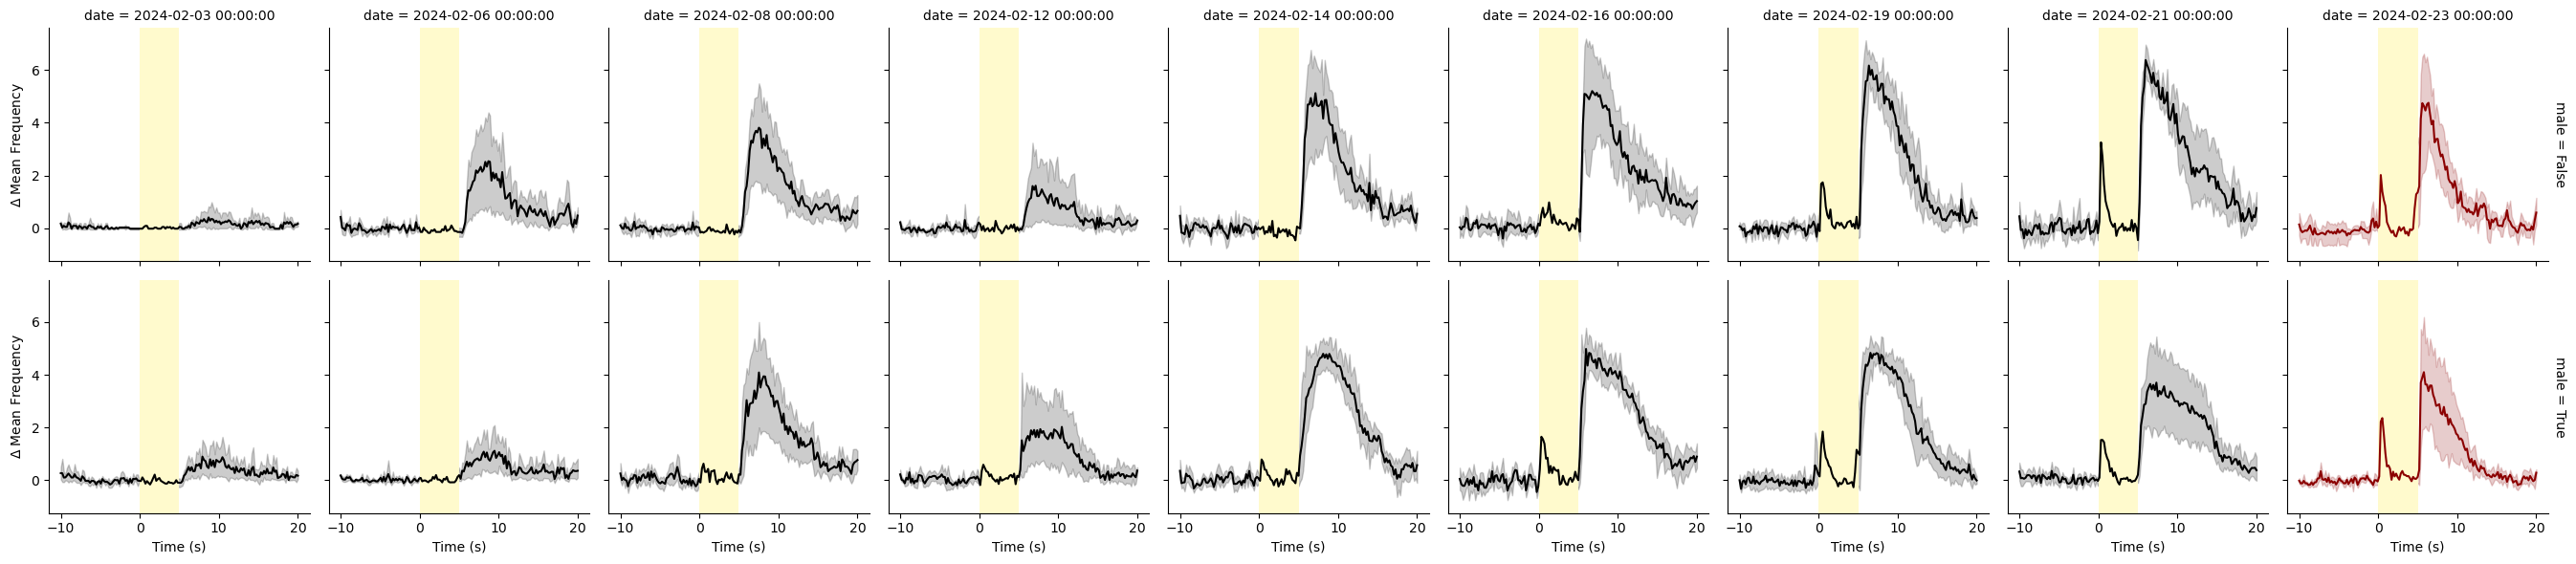

In [160]:
every_other_day = baseline_corrected_df['date'].unique()[2::2]



facet = sns.FacetGrid(baseline_corrected_df
                      .filter(pl.col('date').is_in(every_other_day)), 
                      col='date',
                      row = 'male',
                      hue = 'sucralose',
                      palette=['black', 'darkred'],
                      height=3,
                      aspect=1, 
                      margin_titles=True)
facet.map(sns.lineplot, 'time',
          'lick_aligned_to_cue_baseline_corrected')
# facet.map(sns.lineplot, 'time','encoder_aligned_to_cue_baseline_corrected', color = 'grey')
for ax in facet.axes.flat:
    draw_cue_box(ax, color='lemonchiffon', alpha=1)
    ax.set_ylabel(r'$\Delta$ Mean Frequency')
    ax.set_xlabel('Time (s)')
# facet.figure.text(-0.5, 2, 'Lick', color = 'lightblue', size = 20)
    

### mean anticipatory licks

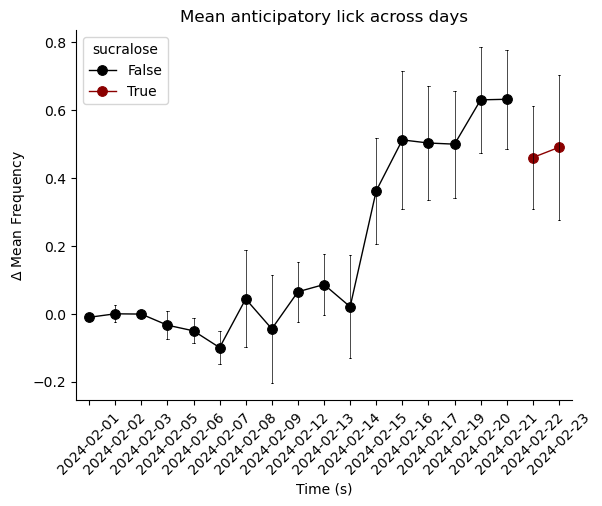

In [246]:
grouped_baseline_al =(
    baseline_corrected_df
             .filter(
                 (pl.col('time') >0) 
                 & 
                 (pl.col('time') <3)
                #  & 
                #  (pl.col('date').is_in(every_other_day))
                )
             .group_by(['subject', 'date', 'sucralose'])
             .agg([
                 pl.col('lick_aligned_to_cue_baseline_corrected').mean().alias(
                     'mean_cue_lick'),
                 pl.col('lick_aligned_to_cue_baseline_corrected').max().alias(
                     'max_cue_lick')
             ])
             .sort('date')
             .with_columns(
                 (pl.col('subject').cast(pl.Int64))
             )
             
)
def plot_anticipatory_licks(col, title):
    
    sns.pointplot(data = grouped_baseline_al,
                x = 'date',
                y=col,
                hue = 'sucralose',
                palette=['black', 'darkred'],
                errorbar='se', 
                linewidth=1, 
                color = 'black',
                markersize = 7,
                capsize=0.1,
                err_kws = {"color":'black', 
                            "linewidth": .5},
                
                )

    plt.xticks(rotation=45)
    plt.ylabel(r'$\Delta$ Mean Frequency')
    plt.xlabel('Time (s)')
    plt.title(title)
    sns.despine()
    plt.show()
plot_anticipatory_licks('mean_cue_lick', 'Mean anticipatory lick across days')


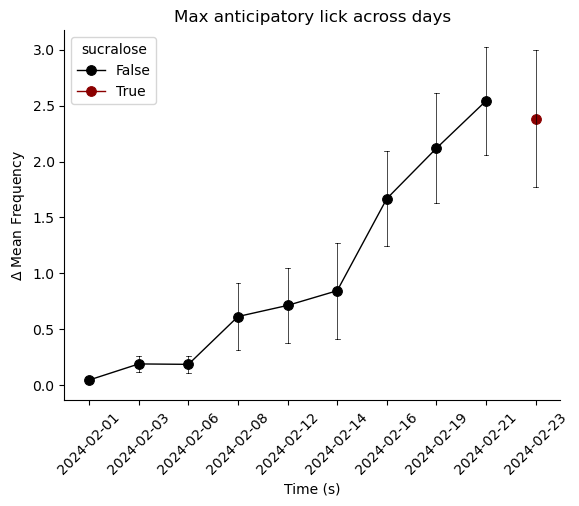

In [170]:
plot_anticipatory_licks('max_cue_lick', 'Max anticipatory lick across days')

#### read fp data and calculate group average

In [247]:
#processing is dropping males coloumns
fp_df = pl.read_parquet(fp_path).drop(
    "__index_level_0__").sort('date').sort('subject')
grouped_fp = (fp_df
              .drop('time', 'trial', 'user')
              .group_by(*[c for c in fp_df.columns if c not in ['z_score', 'time', 'trial', 'user']])
              .mean()
              .with_columns(pl.col('date').cast(pl.Date))
              )

        
# fp_df['subject'].replace('3813', '3813_1')
# sns.scatterplot(data = auc.query("structures == 'LHA'"), x = 'date', y = 'auc', hue = 'behavioral_events', palette = 'Set2')
grouped_fp
# fp_df.with_columns(pl.col('subject').is_in(configs.config_data['males']).alias('males'))
# type(configs.config_data['males'][0])


timestamps,behavioral_events,structures,subject,date,male,sucralose,z_score
f32,cat,cat,i64,date,bool,bool,f32
-2.185175,"""reward""","""LHA""",117,2024-02-01,false,false,-0.074915
-1.103811,"""reward""","""LHA""",117,2024-02-01,false,false,-0.007605
-0.513976,"""reward""","""LHA""",117,2024-02-01,false,false,0.031878
-0.219058,"""reward""","""LHA""",117,2024-02-01,false,false,0.016651
3.221647,"""reward""","""LHA""",117,2024-02-01,false,false,-0.034332
3.516565,"""reward""","""LHA""",117,2024-02-01,false,false,-0.019046
6.760658,"""reward""","""LHA""",117,2024-02-01,false,false,0.019689
10.103057,"""reward""","""LHA""",117,2024-02-01,false,false,0.029205
15.706491,"""reward""","""LHA""",117,2024-02-01,false,false,0.136463


# Cue Response

In [232]:

def plot_fp_response(event):
    filtered_data = (grouped_fp
                     .filter(
                         (pl.col('behavioral_events') == event)
                         & 
                         (pl.col('date').is_in(every_other_day))
                         )
                     )

                        


    facet = sns.FacetGrid(filtered_data, 
                          row = 'structures',
                          col='date',
                          hue = 'sucralose',
                          palette=['black', 'red'],
                          height=3,
                          aspect=1,
                          margin_titles=True)
    facet.map(sns.lineplot, 'timestamps', 'z_score', errorbar='se')
    for ax in facet.axes.flat:
        ax.axvline(5, color='black', linestyle='--')
        draw_cue_box(ax, color='yellow', alpha=0.3)
    plt.legend(loc='upper left')
    plt.tight_layout()

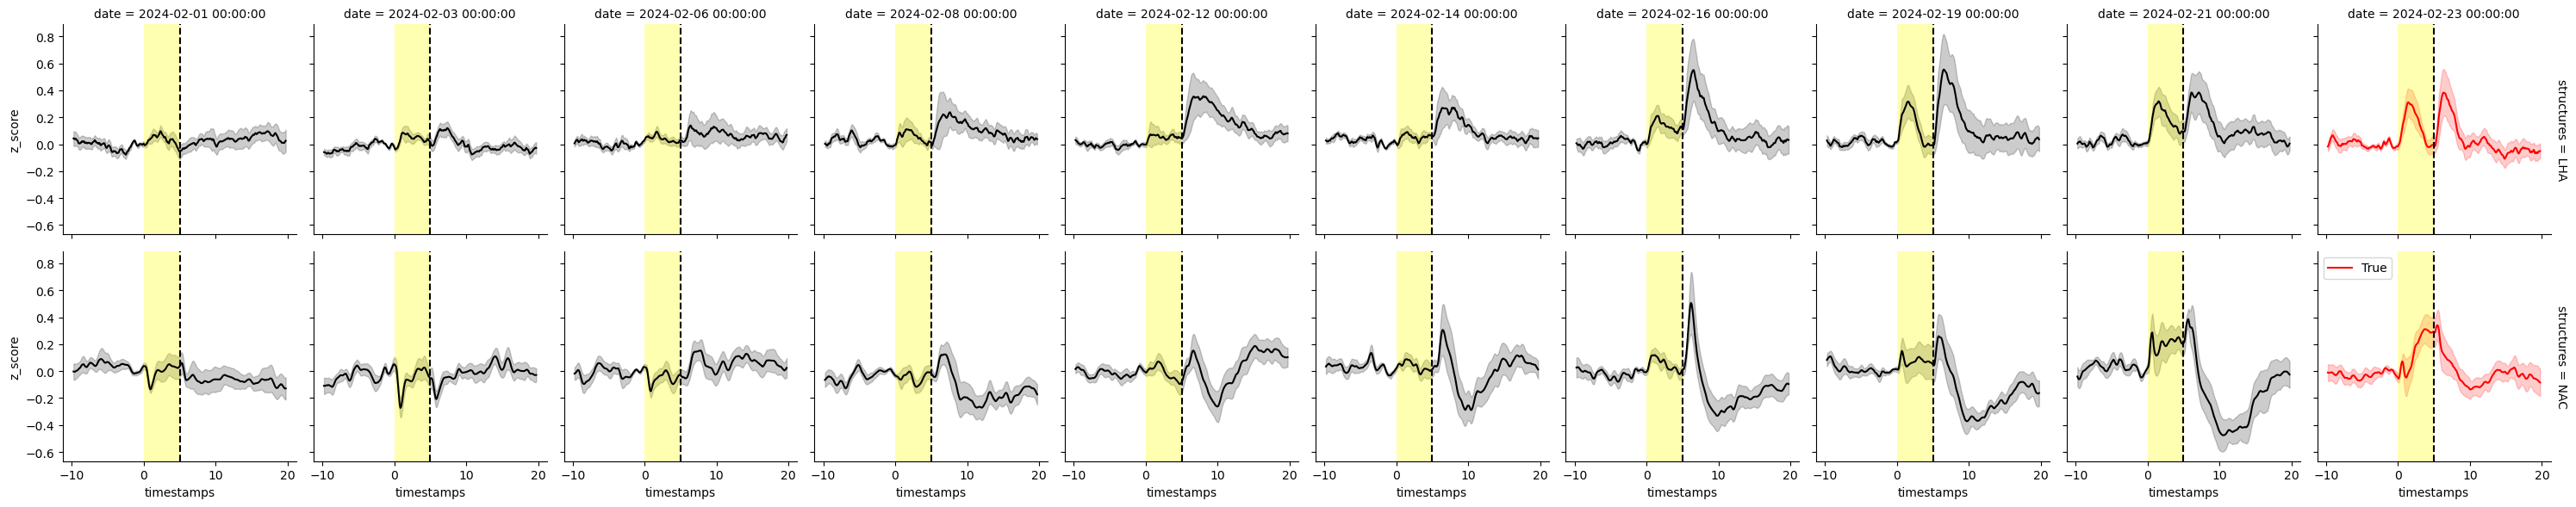

In [233]:
plot_fp_response('cue')

# Reward Response

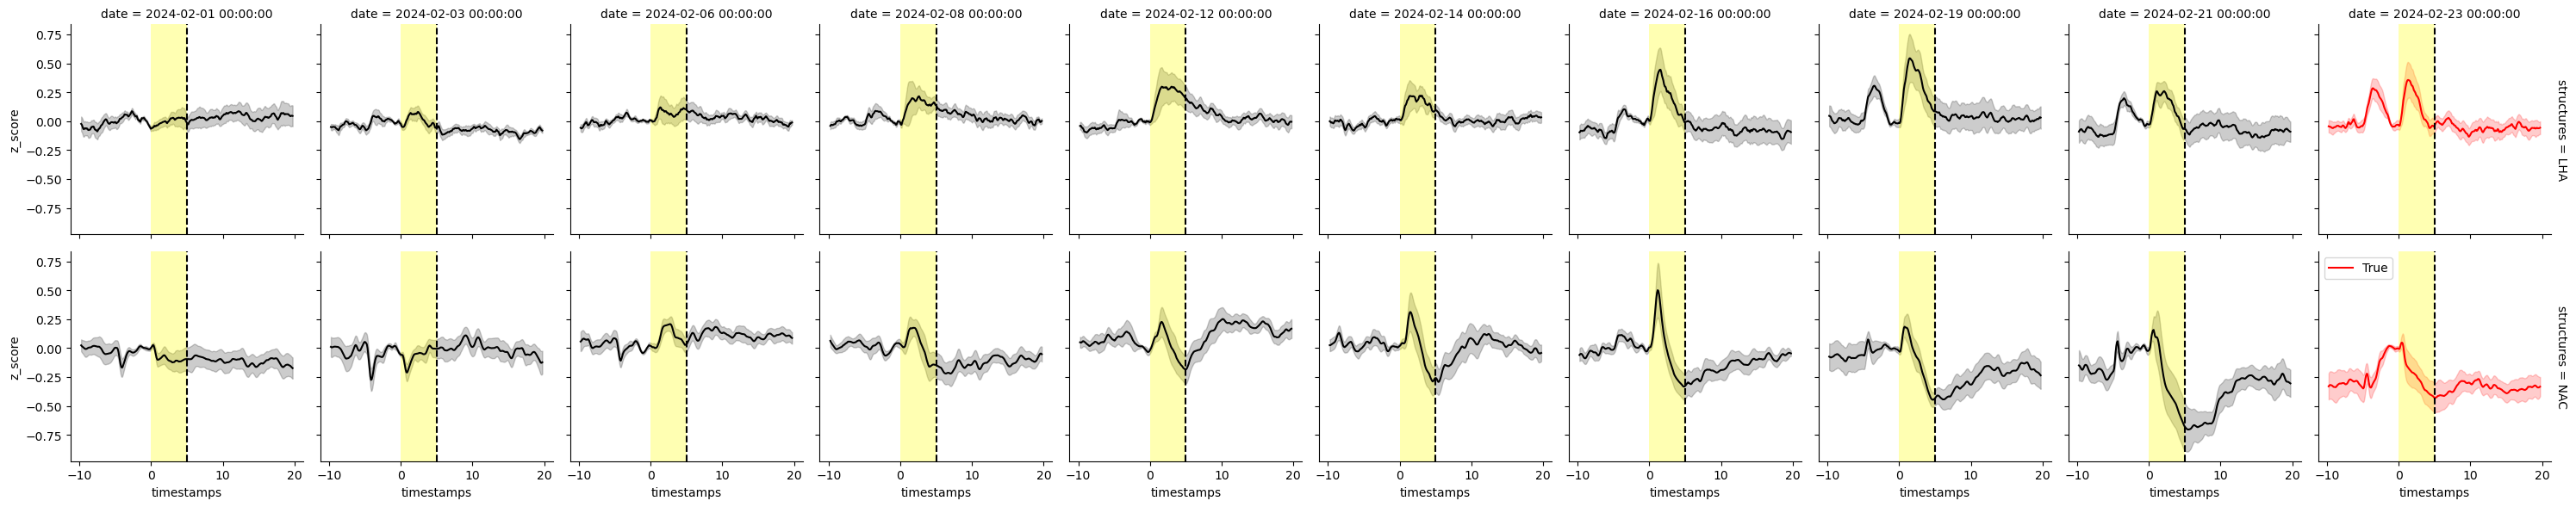

In [234]:
plot_fp_response('reward')

# Individual Cue Response

LHA cue response over days with anticipatory licks

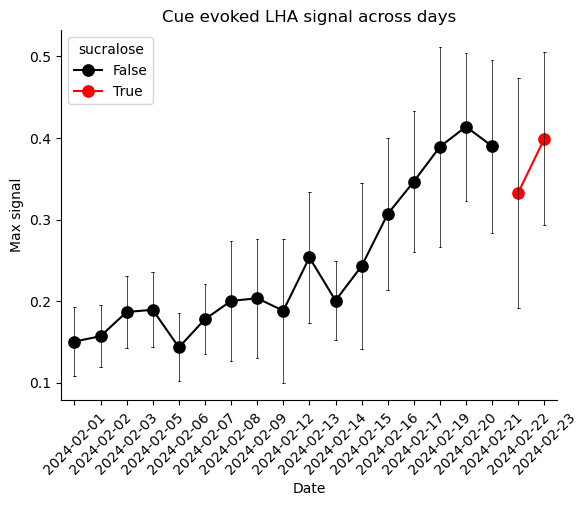

In [248]:

fp_anticipatory = (
    grouped_fp
    .rename({'z_score': 'signal'})
    .filter(
        (pl.col('timestamps') > 0)
        &
        (pl.col('timestamps') < 5)
        # & 
        # (pl.col('date').is_in(every_other_day)) = 
    )
    .group_by(['subject', 'date', 'structures', 'behavioral_events', 'male', 'sucralose'])
    .agg([
        pl.col('signal').max().alias('max_signal'),
        pl.col('signal').mean().alias('mean_signal'),
        pl.col('signal').min().alias('min_signal'),
        pl.col('signal').sum().alias('sum_signal'),
    ])
    .sort('date')
)

sns.pointplot(data=fp_anticipatory.to_pandas().query(
    "structures =='LHA' & behavioral_events == 'cue'"),
              x='date', 
              y='max_signal',
              errorbar='se', 
              linewidth=1.5, 
              palette=['black', 'red'],
              hue = 'sucralose',
            #   color = 'black',
              capsize=0.1,
              err_kws = {"color":'black', 
                        "linewidth": .5},
              **{
                  'marker': 'o',
                  'markersize': 8, 
              }
             )
plt.xticks(rotation=45)
plt.ylabel(r'Max signal')
plt.xlabel('Date')
plt.title('Cue evoked LHA signal across days')
sns.despine()
plt.show()

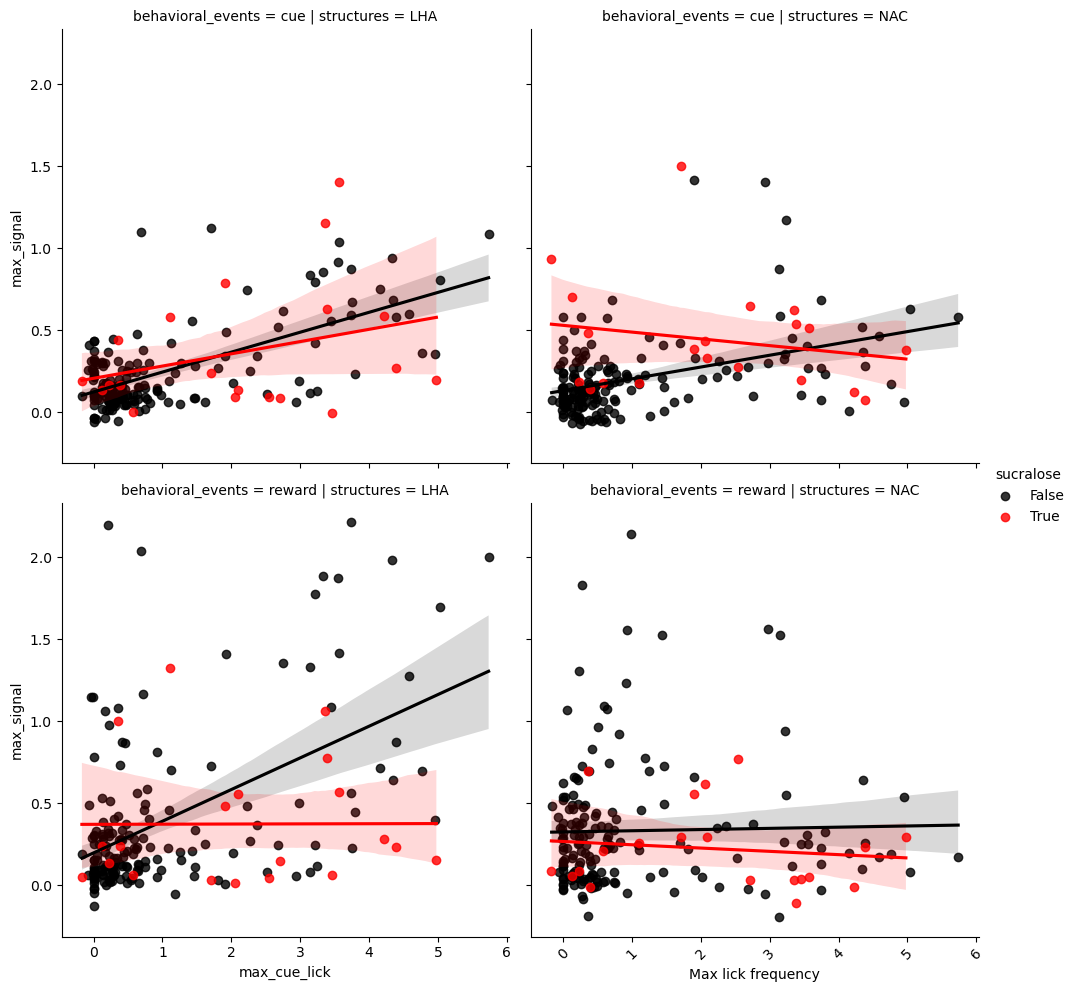

In [250]:



combined_anticipatory_data = (fp_anticipatory
                 .join(grouped_baseline_al, on = ['subject', 'date']).sort('date')
                #  .filter(pl.col('date')>filter_date)
                )



sns.lmplot(data=combined_anticipatory_data,
           x='max_cue_lick',
            y = 'max_signal', 
            col = 'structures',
            col_order = ['LHA', 'NAC'],
            row = 'behavioral_events',
            row_order = ['cue', 'reward'],
            hue = 'sucralose',
            palette=['black', 'red']
            )
plt.xticks(rotation=45)
plt.ylabel('Max LHA Dopamine')
plt.xlabel('Max lick frequency')
# .title('Cue Evoked Max LHA Dopamine vs Max Lick Frequency')
sns.despine()

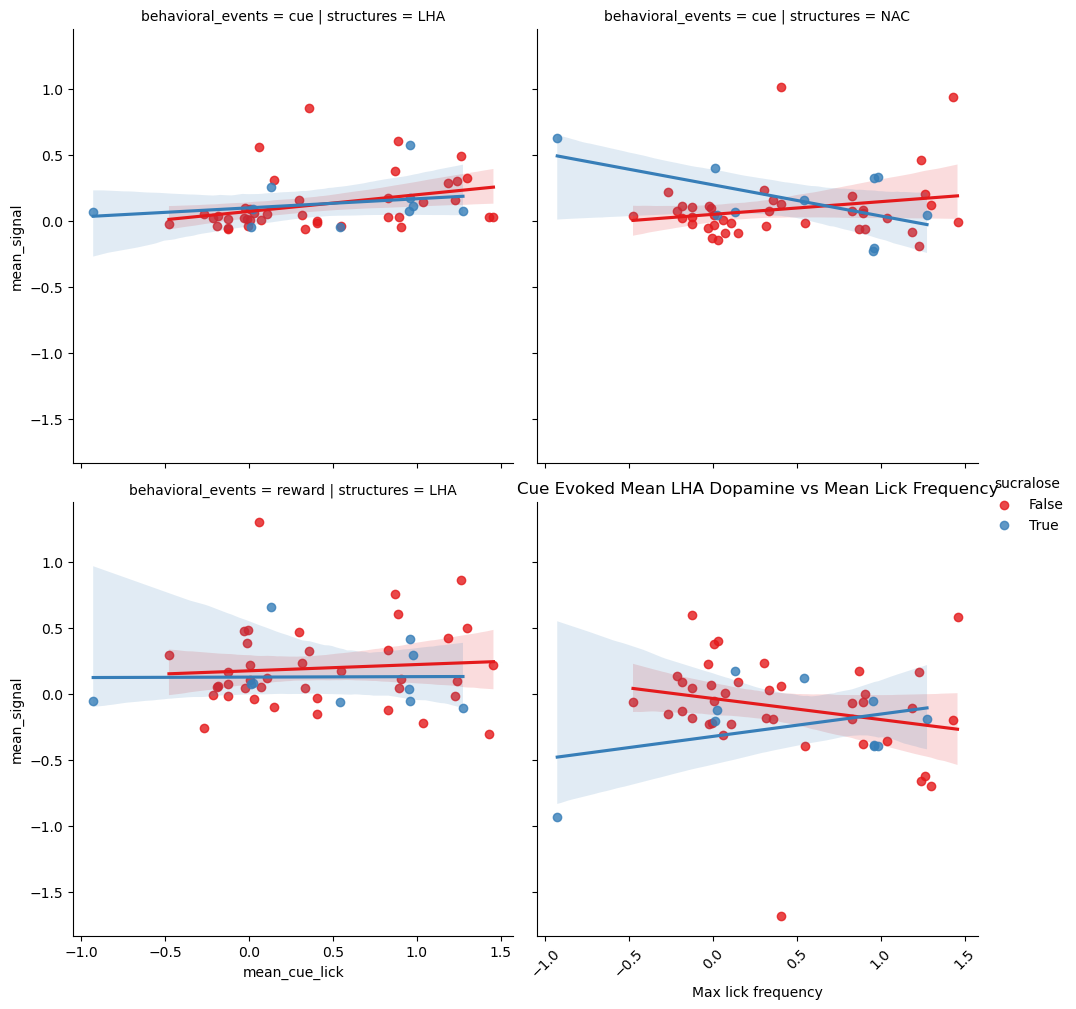

In [192]:
sns.lmplot(data=combined_anticipatory_data,
        y = 'mean_signal',
        x='mean_cue_lick',
        col='structures',
        col_order=['LHA', 'NAC'],
        row='behavioral_events',
        row_order=['cue', 'reward'],
        hue='sucralose',
        palette='Set1'
)
plt.xticks(rotation=45)
plt.ylabel('Max LHA Dopamine')
plt.xlabel('Max lick frequency')
plt.title('Cue Evoked Mean LHA Dopamine vs Mean Lick Frequency')
sns.despine()
plt.show()

In [203]:
auc = (
    pl.from_pandas(
    grouped_fp
    .filter(
        (pl.col('timestamps') > 0)
        &
        (pl.col('timestamps') < 5)
    )
    .drop('time', 'trial', 'user')
    .sort(['subject', 'behavioral_events', 'structures', 'timestamps', 'date'])
    .to_pandas()
    .groupby(by=['behavioral_events', 'structures', 'subject', 'date'], as_index=False, observed=False)
    .apply(lambda x: np.trapz(x['z_score'], x['timestamps'])).rename({None: 'auc'}, axis=1)
    )
    .with_columns(
        (pl.col('date').cast(pl.Date))
        )
                  
)

final_data = combined_anticipatory_data.join(
    auc, on=['subject', 'date', 'structures', 'behavioral_events']).sort('date')
final_data

/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_17681/1061212051.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.trapz(x['z_score'], x['timestamps'])).rename({None: 'auc'}, axis=1)


subject,date,structures,behavioral_events,male,sucralose,max_signal,mean_signal,min_signal,sum_signal,sucralose_right,mean_cue_lick,max_cue_lick,auc
i64,date,cat,cat,bool,bool,f32,f32,f32,f32,bool,f64,f64,f32
117,2024-02-14,"""LHA""","""reward""",false,false,0.204315,0.056838,-0.053424,2.898751,false,-0.1875,1.25,0.287651
3634,2024-02-14,"""LHA""","""reward""",true,false,1.274473,0.500922,-0.070469,25.547031,false,1.298611,4.583333,2.509991
3812,2024-02-14,"""LHA""","""reward""",true,false,0.276379,0.063899,-0.133252,3.258866,false,-0.185185,0.37037,0.320752
3814,2024-02-14,"""LHA""","""reward""",true,false,0.530332,0.295592,0.104109,15.075172,false,-0.476562,0.1171875,1.463747
3816,2024-02-14,"""LHA""","""reward""",true,false,0.187851,0.119275,-0.001567,6.08302,false,0.10625,0.572917,0.594705
3818,2024-02-14,"""LHA""","""reward""",false,false,-0.00044,-0.253847,-0.472521,-12.94618,false,-0.265086,0.18319,-1.263921
3819,2024-02-14,"""LHA""","""reward""",false,false,0.064129,-0.017247,-0.121245,-0.879582,false,-0.126543,0.231481,-0.080744
3820,2024-02-14,"""LHA""","""reward""",false,false,0.309306,0.222674,0.088266,11.356372,false,0.004167,0.508929,1.095311
5079,2024-02-14,"""LHA""","""reward""",false,false,0.241487,0.055461,-0.238836,2.828515,false,0.071429,0.178571,0.258156


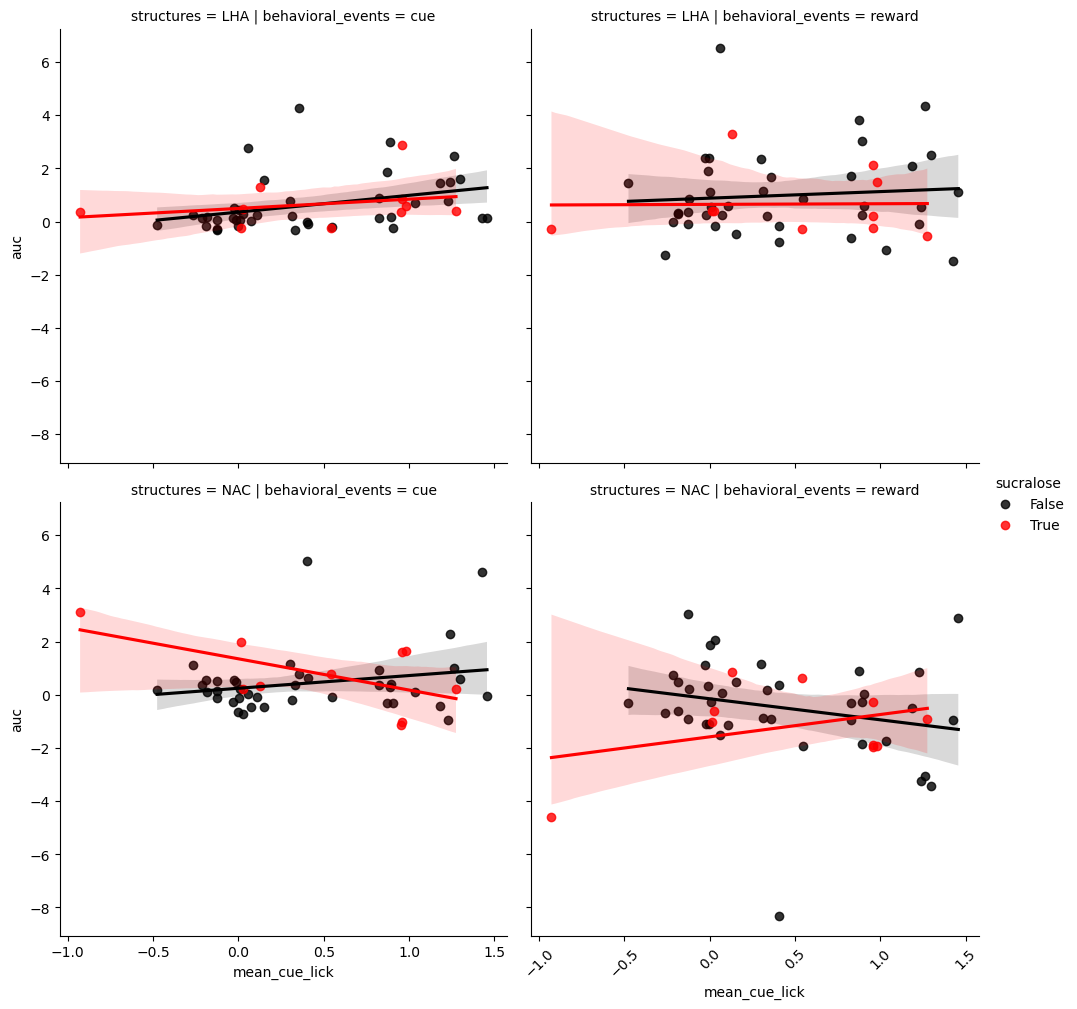

In [206]:

trained_data = final_data.filter(
    pl.col('date')>filter_date
)
sns.lmplot(data=trained_data,
           x='mean_cue_lick',
           y='auc', 
           hue = 'sucralose', 
           col = 'behavioral_events',
           col_order=['cue', 'reward'], 
           row = 'structures',  
           row_order = ['LHA', 'NAC'],
           palette=['black', 'red']
)
plt.xticks(rotation=45)
plt.ylabel('Mean LHA Dopamine')
# plt.xlabel('Mean lick frequency')
# plt.title('Cue Evoked Mean LHA Dopamine vs Mean Lick Frequency')
sns.despine()
plt.show()

### read behavior data and baseline correct from -3 to 0